# 04: ML Classification - QoE Degradation Prediction

This notebook predicts Low QoE events using classification models.

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from src.telecom_qoe_analytics.data_loader import get_merged_dataset, get_time_split, create_qoe_targets, setup_plotting, get_categorical_features

setup_plotting(context="paper", palette="deep", style="ticks")
df = get_merged_dataset()
df = create_qoe_targets(df)

📈 Plotting environment set: style=ticks, palette=deep, context=paper


## 1. Preprocessing & Class Imbalance

In [2]:
cat_cols = get_categorical_features(df)
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

train_df, val_df, test_df = get_time_split(df)

X_train = train_df.drop(columns=["qoe_score", "low_qoe", "qoe_tier", "session_id", "user_id", "cell_id", "timestamp_start"])
y_train = train_df["low_qoe"]
X_test = test_df.drop(columns=["qoe_score", "low_qoe", "qoe_tier", "session_id", "user_id", "cell_id", "timestamp_start"])
y_test = test_df["low_qoe"]

print("Class distribution in training set:", y_train.value_counts(normalize=True))

Class distribution in training set: low_qoe
0    0.900138
1    0.099862
Name: proportion, dtype: float64


## 2. Model Training (LightGBM)

In [3]:
# Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": [31, 50, 70],
    "max_depth": [-1, 10, 20],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0]
}

base_model = LGBMClassifier(class_weight="balanced", random_state=42, verbose=-1)

# Run RandomizedSearchCV
search = RandomizedSearchCV(
    base_model,
    param_grid,
    n_iter=10,
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
search.fit(X_train, y_train)

print(f"Best params: {search.best_params_}")
model = search.best_estimator_

test_probs = model.predict_proba(X_test)[:, 1]
test_preds = model.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


## 3. Evaluation Metrics

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38038
           1       0.97      1.00      0.98      4079

    accuracy                           1.00     42117
   macro avg       0.99      1.00      0.99     42117
weighted avg       1.00      1.00      1.00     42117

ROC-AUC Score: 1.0000


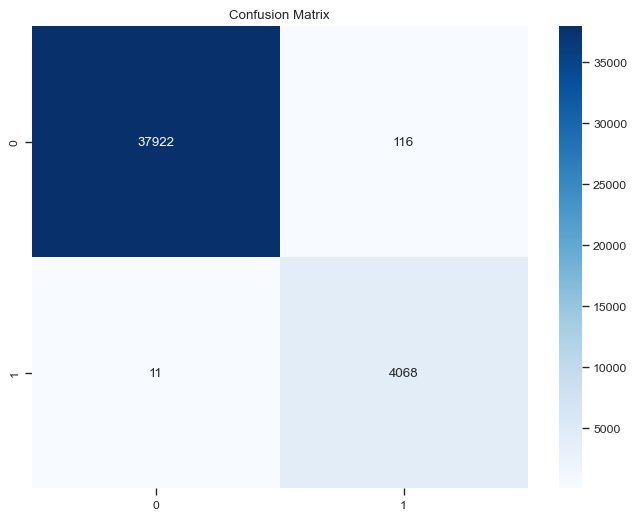

In [4]:
print(classification_report(y_test, test_preds))
print(f"ROC-AUC Score: {roc_auc_score(y_test, test_probs):.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, test_preds), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

### 💡 How to read this: Classification Metrics
* **Precision:** When the model says "Low QoE," how often is it right? (Important to avoid 'false alarms' for customer support).
* **Recall:** Out of all users who *actually* had a bad time, how many did the model catch? (Important to fix as many issues as possible).
* **F1-Score:** The harmonic mean of the two. Use this to compare models overall.


## 4. Precision-Recall Curve

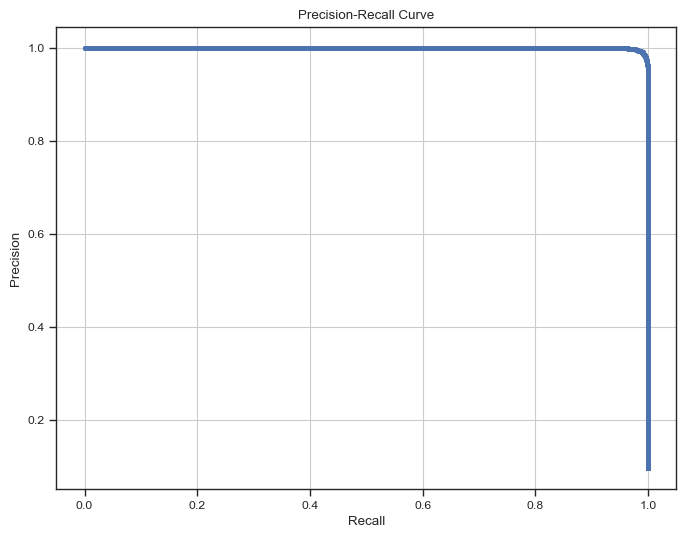

In [5]:
precision, recall, _ = precision_recall_curve(y_test, test_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker=".")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

### 💡 How to read this: PR Curve
* **The Goal:** To have a curve that stays as close to the top-right corner as possible.
* **The Trade-off:** As you try to catch more bad QoE events (increase Recall), your Precision usually drops. The "best" spot depends on your business cost for false alarms.
